In [1]:
from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [10]:
num_epochs = 10
total_series_length = 50000
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length
num_layers = 3

In [4]:
def generateData():
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))

    return (x, y)

In [5]:
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [num_layers, 2, batch_size, state_size])

state_per_layer_list = tf.unstack(init_state, axis=0)
rnn_tuple_state = tuple(
    [tf.contrib.rnn.LSTMStateTuple(state_per_layer_list[idx][0], state_per_layer_list[idx][1])
     for idx in range(num_layers)]
)

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

In [6]:
# Forward passes
cell = tf.contrib.rnn.LSTMCell(state_size, state_is_tuple=True)
cell = tf.contrib.rnn.MultiRNNCell([cell] * num_layers, state_is_tuple=True)
states_series, current_state = tf.nn.dynamic_rnn(cell, tf.expand_dims(batchX_placeholder, -1), initial_state=rnn_tuple_state)
print(states_series.shape)
states_series = tf.reshape(states_series, [-1, state_size])
print(states_series.shape)

(5, 15, 4)
(75, 4)


In [7]:
logits = tf.matmul(states_series, W2) + b2 #Broadcasted addition
print(logits.shape)
labels = tf.reshape(batchY_placeholder, [-1])
print(labels.shape)

logits_series = tf.unstack(tf.reshape(logits, [batch_size, truncated_backprop_length, num_classes]), axis=1)
print(len(logits_series))
print(logits_series[0].shape)
predictions_series = [tf.nn.softmax(logit) for logit in logits_series]


losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)
total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

(75, 2)
(75,)
15
(5, 2)


In [8]:
def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


New data, epoch 0
Step 0 Batch loss 0.69349
Step 100 Batch loss 0.69132
Step 200 Batch loss 0.636128
Step 300 Batch loss 0.565442
Step 400 Batch loss 0.35266
Step 500 Batch loss 0.206552
Step 600 Batch loss 0.0972039
New data, epoch 1
Step 0 Batch loss 0.471239
Step 100 Batch loss 0.00641255
Step 200 Batch loss 0.00305342
Step 300 Batch loss 0.0023947
Step 400 Batch loss 0.00168221
Step 500 Batch loss 0.00132188
Step 600 Batch loss 0.00113517
New data, epoch 2
Step 0 Batch loss 0.312502
Step 100 Batch loss 0.00141916
Step 200 Batch loss 0.00103355
Step 300 Batch loss 0.000872041
Step 400 Batch loss 0.000667584
Step 500 Batch loss 0.000712787
Step 600 Batch loss 0.00061919
New data, epoch 3
Step 0 Batch loss 0.394769
Step 100 Batch loss 0.000577867
Step 200 Batch loss 0.00052149
Step 300 Batch loss 0.000481438
Step 400 Batch loss 0.000463577
Step 500 Batch loss 0.000425726
Step 600 Batch loss 0.000344236
New data, epoch 4
Step 0 Batch loss 0.411185
Step 100 Batch loss 0.000416227
Step 2

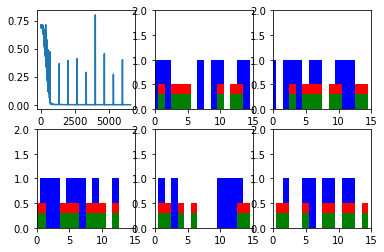

In [11]:
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []

    for epoch_idx in range(num_epochs):
        x,y = generateData()

        _current_state = np.zeros((num_layers, 2, batch_size, state_size))

        print("New data, epoch", epoch_idx)

        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]

            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder: batchX,
                    batchY_placeholder: batchY,
                    init_state: _current_state
                })


            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Batch loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()